In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'data\raw\test-images\gtFine\train\zurich\zurich_000000_000019_gtFine_labelIds.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert the image to a numpy array
image_matrix = np.array(image)

# Print the matrix
print(image_matrix)

print(image_matrix[450][1100])

# Display the image
plt.imshow(image_matrix, cmap='gray')
plt.colorbar()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data\\raw\\test-images\\gtFine\\train\\zurich\\zurich_000000_000019_gtFine_labelIds.png'

In [5]:
import cv2
from labeling.image_load_util import load_folder_image, get_full_path_from_root
from utils.serialize import read_clusters, read_matrix
import os

matrix_file = open("data/slic/full_slic_matrix.bin", "rb")
cluster_file = open("data/slic/full_slic_cluster.bin", "rb")
print("Files loaded")

# Load the matrix and cluster
matrix = read_matrix(matrix_file) # Matrix size image, pixel corresponds to cluster
cluster = read_clusters(cluster_file) # Cluster ID, avg colour and centroid. 

image_directory = 'data/raw/test-images/leftImg8bit/train'

image_filenames =  load_folder_image(image_directory)

id_directory = 'data/raw/test-images/gtFine/train' # This is the ground truth labels
search_string = 'label'  # Replace this with the substring you want to match
id_filenames = []

all_filenames = load_folder_image(id_directory)
for id in all_filenames:
    if search_string in str(id):
        id_filenames.append(id)


matrix_file.close()
cluster_file.close()

Files loaded
Loaded folder of images: data/raw/test-images/leftImg8bit/train


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\David\\DataspellProjects\\SemanticSegmentation\\data/raw/test-images/leftImg8bit/train'

In [45]:
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import dump, load

# current feature extraction method - mean color and centroid
def extract_features_from_clusters(cluster_matrix):
    features = []
    for cluster in cluster_matrix:
        mean_color = [cluster.l, cluster.a, cluster.b] 
        centroid = [cluster.x, cluster.y]
        feature_vector = mean_color + centroid
        # feature_vector = centroid
        features.append(feature_vector)
    return np.array(features)

def prepare_training_data(cluster_matrices, ground_truth_matrices, slic_matrix):
    X_train, y_train = [], []
    i = 0
    j = 0
    cluster_labels = []
    for clusters, gt in zip(cluster_matrices, ground_truth_matrices):
        features = extract_features_from_clusters(clusters)
        # print("Features: ", features)
        # print("Ground Truth Size: ", np.shape(ground_truth_matrices))
        for cluster in clusters:
            gt = ground_truth_matrices[j]
            cid = cluster.cid
            # print("Slic Matrix: ",slic_matrix[j])
            # print("Cluster ID: ",cid)
            mask = (slic_matrix[j] == (int(cid+1)))
            # print("Mask: ",mask)
            # print("Ground Truth: ", gt)
            labels, counts = np.unique(gt[mask], return_counts=True)
            # print(labels)
            # print(counts)
            dominant_label = labels[np.argmax(counts)]
            y_train.append(dominant_label)
            i += 1
            if i%510 == 0:
                j += 1
                break

        X_train.extend(features)

    return np.array(X_train), np.array(y_train)


def train_svm(X_train, y_train):
    scaler = StandardScaler()
    svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    pipeline = make_pipeline(scaler, svm)

    pipeline.fit(X_train, y_train)
    return pipeline

def predict_cluster_labels(cluster_matrix, model, segments):
    features = extract_features_from_clusters(cluster_matrix)
    predictions = model.predict(features)
    
    segmentation_result = np.zeros(segments.shape, dtype=np.int32)
    for cluster, label in zip(cluster_matrix, predictions):
        cid = cluster.cid
        segmentation_result[segments == cid] = label

    return segmentation_result

In [8]:
cluster_cell = []
matrix_cell = []
matrix_file = open("data/slic/full_slic_matrix.bin", "rb")
cluster_file = open("data/slic/full_slic_cluster.bin", "rb")


for i in range(0,3):
    cluster_cell.append(read_clusters(cluster_file))
    matrix_cell.append(read_matrix(matrix_file))



print(matrix_cell[0])
print(cluster_cell[0][10])
matrix_file.close()
cluster_file.close()

[[  1   1   1 ...  62  62  62]
 [  1   1   1 ...  62  62  62]
 [  1   1   1 ...  62  62  62]
 ...
 [480 480 480 ... 511 511 511]
 [480 480 480 ... 511 511 511]
 [480 480 480 ... 511 511 511]]
PyCluster(x=704.5319213867188, y=24.520620346069336, l=44.12792205810547, a=0.0, b=4.532702922821045, n=3807, cid=10)


In [54]:
id_directory = 'src/classification/data/raw/test-images/gtFine/train'
# search_string = 'instance'  # Replace this with the substring you want to match
search_string = 'label'  # Replace this with the substring you want to match
id_filenames = []

all_filenames = load_folder_image(id_directory)
for id in all_filenames:
    if search_string in str(id):
        id_filenames.append(id)
        
ground_truth_matrices = []
for id_filename in id_filenames:
    ground_truth_matrices.append(cv2.imread(id_filename, cv2.IMREAD_GRAYSCALE))

Loaded folder of images: src/classification/data/raw/test-images/gtFine/train
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\aachen
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\bochum
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\bremen
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\cologne
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\darmstadt
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\src/classification/data/raw/test-images/gtFine/train\dusseldorf
Loaded folder of images: C:\Users\David\DataspellProjects\SemanticSegmentation\s

In [55]:
print(np.shape(ground_truth_matrices))

(2975, 1024, 2048)


In [58]:
matrix_file = open("data/slic/full_slic_matrix.bin", "rb")
cluster_file = open("data/slic/full_slic_cluster.bin", "rb")
appended_gt = []
matrix_cell = []
cluster_cell = []


for i in range(0,10):
    cluster_cell.append(read_clusters(cluster_file))
    matrix_cell.append(read_matrix(matrix_file))
    appended_gt.append(ground_truth_matrices[i])


x_train, y_train = prepare_training_data(cluster_cell, appended_gt, matrix_cell)
matrix_file.close()
cluster_file.close()

In [59]:
# print(x_train)
print(np.shape(y_train))

(5100,)


In [60]:
model = train_svm(x_train[0:2500], y_train[0:2500]) # Train on the first 2500 samples

In [62]:
test_image = 9 # 9 at 77.5%
predicted_labels = predict_cluster_labels(cluster_cell[test_image], model, matrix_cell[test_image])

In [63]:
def calculate_matching_percentage(matrix1, matrix2):
    # Ensure both matrices have the same shape
    if np.shape(matrix1) != np.shape(matrix2):
        raise ValueError("Matrices must have the same shape")

    # Compare the matrices element-wise
    matching_elements = (matrix1 == matrix2)

    # Calculate the percentage of matching values
    matching_percentage = np.sum(matching_elements) / matching_elements.size * 100

    return matching_percentage

In [64]:
percentage = calculate_matching_percentage(predicted_labels, appended_gt[test_image])

print(f"Matching percentage: {percentage:.2f}%")

Matching percentage: 77.54%


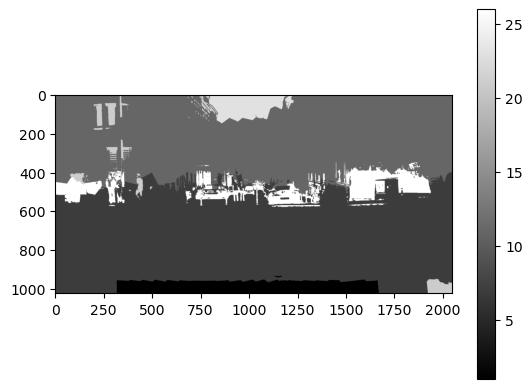

In [65]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(predicted_labels, cmap='gray')
plt.colorbar()


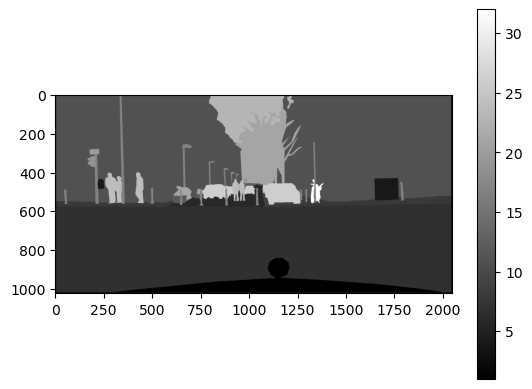

In [66]:
plt.imshow(appended_gt[test_image], cmap='gray')
plt.colorbar()